# **Heatwave identification from CMCC**

This code identifies HW periods over the wider Milan area for the period between 1981-2021.
It's based on the ERA5 downscaled dataset over Italy from CMCC. Data resolution is 2.2km, and time frequency is one hour (the same as original ERA5 product).
More information is available here: https://dds.cmcc.it/#/dataset/era5-downscaled-over-italy

In [1]:
import numpy as np                      
from matplotlib import pyplot as plt   
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import xarray as xr                       # for netcdf
import pandas as pd   
import geopandas as gpd
import os
import rasterio
import rioxarray as rio
from rasterio.transform import from_origin
from rasterio.crs import CRS
from scipy.interpolate import griddata
from shapely.geometry import Point

### NetCDF file pre-processing
NetCDF is multi-dimensional data storage format, sometimes tricky to handle. Let's inspect this dataset. 

In [2]:
file_path = ".//Data//era5-downscaled-over-italy-CML.nc"
ds = xr.open_dataset(file_path)
ds.lon

<xarray.DataArray 'lon' (rlat: 27, rlon: 36)> Size: 4kB
[972 values with dtype=float32]
Coordinates:
    lon        (rlat, rlon) float32 4kB ...
    height_2m  float32 4B ...
  * rlon       (rlon) float64 288B -2.333 -2.313 -2.293 ... -1.673 -1.653 -1.633
  * rlat       (rlat) float64 216B 2.232 2.252 2.272 2.292 ... 2.712 2.732 2.752
    lat        (rlat, rlon) float32 4kB ...
Attributes:
    standard_name:        longitude
    long_name:            longitude
    _CoordinateAxisType:  Lon
    units:                degrees_east

In [3]:
# We are interested in the air temperature variable, but we will convert Kelvins to °C. New variable is 'ds_c'.
ds.time
ds_c = ds.assign(T_2M=ds.T_2M - 273.15)
print(ds_c.lon)

<xarray.DataArray 'lon' (rlat: 27, rlon: 36)> Size: 4kB
[972 values with dtype=float32]
Coordinates:
    lon        (rlat, rlon) float32 4kB ...
    height_2m  float32 4B ...
  * rlon       (rlon) float64 288B -2.333 -2.313 -2.293 ... -1.673 -1.653 -1.633
  * rlat       (rlat) float64 216B 2.232 2.252 2.272 2.292 ... 2.712 2.732 2.752
    lat        (rlat, rlon) float32 4kB ...
Attributes:
    standard_name:        longitude
    long_name:            longitude
    _CoordinateAxisType:  Lon
    units:                degrees_east


#### Move from rlat and rlon to lat and lon
Next we want to stop using rotated grid (rlon and rlat) values (mainly used in atmospheric sciences). We want to keep lon and lat on a regular grid. This information is available in the .nc metadata.

rlat and rlon are 1D data meaning they are stored as a single array with one axis, so only 30 values for rlon and 22 for rlat. However, lat and lon are 2D, and we have coordinates for each pixel, therefore 660 values for lat and lon respectively. To replace rlat/rlon with lat/lon we need to convert lat/lon to 1D. We'll do that by taking the first column and row of lat and lon at rlat and rlon values (which are only 1). 

In [4]:
# Just a note that each lat and lon coordinate have rlat and rlon variable), which allows lat/lon extraction along x and y
ds_final = ds_c.assign_coords(
    lon=("rlon", ds_c.lon.isel(rlat=0).values),  # Take first row of lon
    lat=("rlat", ds_c.lat.isel(rlon=0).values)   # Take first column of lat
)

# Swap dimensions: Replace rlon/rlat with lon/lat
ds_final = ds_final.swap_dims({"rlon": "lon", "rlat": "lat"})
ds_final

<xarray.Dataset> Size: 1GB
Dimensions:                         (time: 361215, lat: 27, lon: 36)
Coordinates:
  * lon                             (lon) float32 144B 8.691 8.719 ... 9.683
    height_2m                       float32 4B ...
    rlon                            (lon) float64 288B -2.333 -2.313 ... -1.633
    rlat                            (lat) float64 216B 2.232 2.252 ... 2.752
  * lat                             (lat) float32 108B 45.19 45.21 ... 45.71
  * time                            (time) datetime64[ns] 3MB 1981-01-01T01:0...
Data variables:
    T_2M                            (time, lat, lon) float32 1GB -0.01993 ......
    crs_rotated_latitude_longitude  int64 8B ...
Attributes: (12/14)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.4
    history:         Generated by CMCC DDS version 0.9.0 2025-05-06 15:25:21....
    source:          COSMO
    institution:     CMCC (Euro-Mediterranean Center on Climate Change), REMH...
    title:           cclm-sp_2.4_terra_urb_2.3.1 simulation (0.02 Deg) forced...
    ...              ...
    conventionsURL:  http://www.cfconventions.org/
    contact:         Mario Raffa (mario.raffa@cmcc.it)- Marianna Adinolfi (ma...
    references:      http//www.clm-community.eu, http://www.cmcc.it
    creation_date:   2022-10-22 00:28:52
    grid_mapping:    rotated_pole
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

In [5]:
# Let's just check if the first column/row or rlat and rlon coincides with the first column/row of lat/lon. We can compare it back to the original nc file upper in the code.
print(f"First row of lon: {ds_c.lon.isel(rlat=0).values}")
print(f"First column of lat: {ds_c.lat.isel(rlon=0).values}")
print(f"rlon values: {ds_c.rlon.values}")
print(f"rlat values: {ds_c.rlat.values}")

First row of lon: [8.69109   8.719423  8.747757  8.776093  8.804428  8.832765  8.861102
 8.889441  8.917779  8.946118  8.974459  9.0028    9.031141  9.059484
 9.087827  9.116171  9.144515  9.17286   9.201205  9.229552  9.257899
 9.286246  9.314594  9.342943  9.371293  9.399643  9.427994  9.456346
 9.484697  9.513049  9.541403  9.5697565 9.59811   9.626465  9.65482
 9.683176 ]
First column of lat: [45.186478 45.206463 45.226444 45.24643  45.266415 45.2864   45.306385
 45.326366 45.34635  45.366337 45.386322 45.406303 45.42629  45.446274
 45.46626  45.486244 45.506226 45.52621  45.546196 45.56618  45.586163
 45.606148 45.626133 45.64612  45.6661   45.686085 45.70607 ]
rlon values: [-2.33324504 -2.31324506 -2.29324508 -2.2732451  -2.25324512 -2.2332449
 -2.21324492 -2.19324493 -2.17324495 -2.15324497 -2.13324499 -2.11324501
 -2.09324503 -2.07324505 -2.05324507 -2.03324509 -2.01324511 -1.99324501
 -1.97324502 -1.95324504 -1.93324494 -1.91324496 -1.89324498 -1.873245
 -1.85324502 -1.8332450

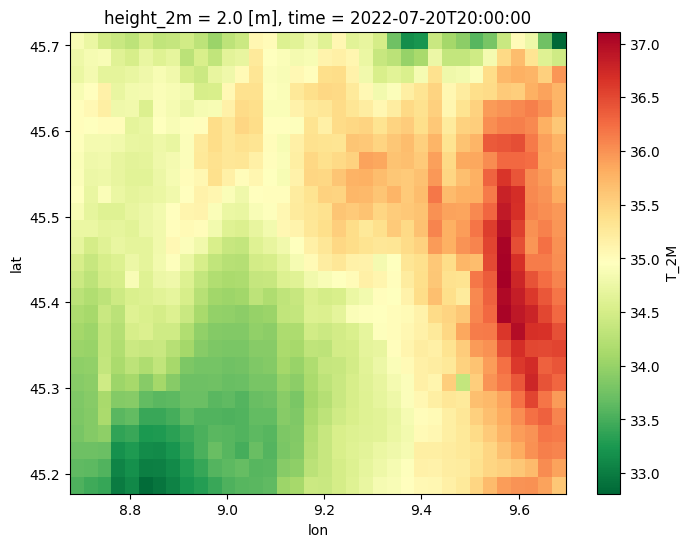

In [6]:
# Plot just one time step to check if pixels look good
data = ds_final["T_2M"].isel(time=349044)

plt.figure(figsize=(8, 6))
data.plot(cmap="RdYlGn_r", x="lon", y="lat")
plt.show()

In [ ]:
# Here we try to export to gpkg with the idea to convert to raster

# Load dataset
file_path = ".//Data//era5-downscaled-over-italy-CML.nc"
ds = xr.open_dataset(file_path)

# Ensure time is decoded as datetime
ds["time"] = xr.decode_cf(ds).time

# Select July 15–26, hours 16 and 17
time_filtered = ds.sel(
    time=((ds["time"].dt.month == 6) &
          (ds["time"].dt.day >= 11) &
          (ds["time"].dt.day <= 21) &
          (ds["time"].dt.hour.isin([5, 6])))
)

# Average over time and convert from Kelvin to Celsius
t2m_mean = time_filtered["T_2M"].mean(dim="time") - 273.15

# Get coordinate arrays
lat = ds["lat"].values
lon = ds["lon"].values

# Meshgrid lat/lon if needed
if lat.ndim == 1 and lon.ndim == 1:
    lon, lat = np.meshgrid(lon, lat)

# Flatten arrays
flat_temp = t2m_mean.values.flatten()
flat_lat = lat.flatten()
flat_lon = lon.flatten()

# Remove NaNs (optional but often necessary)
mask = ~np.isnan(flat_temp)
flat_temp = flat_temp[mask]
flat_lat = flat_lat[mask]
flat_lon = flat_lon[mask]

# Create GeoDataFrame
df = pd.DataFrame({"temperature": flat_temp})
geometry = [Point(xy) for xy in zip(flat_lon, flat_lat)]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Visualization
plt.figure(figsize=(10, 8))
gdf.plot(column="temperature", cmap="RdYlBu_r", legend=True, markersize=20)
plt.title("Avg 2m Air Temperature (°C), MUHI")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# Export to GeoPackage
gdf.to_file("t2m_mean_june11_21_hour5_6.gpkg", driver="GPKG")

In [7]:
print(t2m_interp.rio.crs)

NameError: name 't2m_interp' is not defined

In [ ]:
# Selecting time step
first_band = ds_final.isel(time=5000)  # Extract the first time step

# variable to export
data_var = first_band["T_2M"]

# Ensuring georeferencing information
data_var.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data_var.rio.write_crs("EPSG:4326", inplace=True)  # Set projection (change if needed)

data_var.rio.to_raster(".//outputs//try6.tif")

### Calculate long-term temperature threshold

In this step, we want to calculate the 90th percentile threshold for each pixel in the long dataset (1981 - 2021) based on the 15-day centred window.  We will use that later to define HWs.
We will create two datasets. One is for 2022 (our year of interest), and the other is for 1981-2021, the full period that we use for calculating the HW threshold.

In [9]:
# Clip 2022 only
ds_2022 = ds_c.sel(time=slice("2022-01-01", "2022-12-31"))

# Clip full period for calculating long-term threshold
ds_long = ds_c.sel(time=slice("1981-01-01", "2021-12-31"))

# Clip period that overlaps with ARPA stations (1989-2021) for calculating long-term threshold
ds_arpa_overlap = ds_c.sel(time=slice("1989-01-01", "2021-12-31"))

In [10]:
# Here we calculate long-term daily maximum temperature thresholds. time=1D indicates a time step of one day.
daily_max = ds_long['T_2M'].resample(time='1D').max()

# Full dataset should have 14975 days between 01/01/1981 and 31/12/2021. Let's check if there are some missing days
print(daily_max['time'])

<xarray.DataArray 'time' (time: 14975)> Size: 120kB
array(['1981-01-01T00:00:00.000000000', '1981-01-02T00:00:00.000000000',
       '1981-01-03T00:00:00.000000000', ..., '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height_2m  float32 4B ...
  * time       (time) datetime64[ns] 120kB 1981-01-01 1981-01-02 ... 2021-12-31
Attributes:
    long_name:      time
    axis:           T
    standard_name:  time
    bounds:         time_bnds


In [11]:
# Apply rolling 15-day centered window
rolling_window_15 = daily_max.rolling(time=15, center=True, min_periods=1)
#rolling_window_31 = daily_max.rolling(time=31, center=True, min_periods=1)

In [15]:
# Compute 90th percentile over the entire time period (per pixel)
daily_max_90p_rolling_15 = (
    rolling_window_15.construct("window")
    .reduce(np.percentile, q=90, dim="window")
)

# daily_max_90p_rolling_31 = (
#     rolling_window_31.construct("window")
#     .reduce(np.percentile, q=90, dim="window")
# )

In [17]:
# Collapse per day
daily_max_90p_clim_15 = daily_max_90p_rolling_15.groupby('time.dayofyear').mean('time')
#daily_max_90p_clim_31 = daily_max_90p_rolling_31.groupby('time.dayofyear').mean('time')

In [18]:
daily_max_90p_clim_15

<xarray.DataArray 'T_2M' (dayofyear: 366, rlat: 27, rlon: 36)> Size: 3MB
array([[[6.97346542, 6.92666321, 7.01599579, ..., 7.24667953,
         7.27604813, 7.32509766],
        [6.97536667, 6.93763382, 7.03373596, ..., 7.25946579,
         7.31450699, 7.33338776],
        [7.002117  , 6.97296265, 7.08011887, ..., 7.27587479,
         7.31211731, 7.32639755],
        ...,
        [7.72726791, 7.76714279, 7.73359177, ..., 8.62649933,
         8.49260666, 8.65267303],
        [7.67275406, 7.82421204, 7.87425217, ..., 8.44785416,
         8.05507126, 8.20530579],
        [7.65459366, 7.71193756, 7.59654617, ..., 8.21746979,
         7.8271875 , 7.68909973]],

       [[6.97737061, 6.94889847, 7.04955566, ..., 7.35721115,
         7.39600555, 7.43783112],
        [6.97616745, 6.95376587, 7.0692392 , ..., 7.36501846,
         7.42783905, 7.44665192],
        [6.99853577, 6.98564377, 7.10096207, ..., 7.37473404,
         7.41970901, 7.42911652],
...
        [7.90352631, 7.96385971, 7.9159343 , ..., 8.90470993,
         8.75226517, 8.91647415],
        [7.85602036, 8.02088181, 8.08674957, ..., 8.72653595,
         8.28378311, 8.42434921],
        [7.86939865, 7.93193619, 7.81407288, ..., 8.47563522,
         8.01407028, 7.87901505]],

       [[6.76826172, 6.73295044, 6.82171509, ..., 6.94019531,
         6.95135193, 7.00756836],
        [6.79115051, 6.75524292, 6.83163208, ..., 6.93656677,
         6.98368774, 7.00763611],
        [6.81247375, 6.76430786, 6.83231262, ..., 6.97220886,
         6.98928589, 6.99460876],
        ...,
        [7.48734436, 7.52721619, 7.44813477, ..., 8.29078979,
         8.14269531, 8.32344482],
        [7.39928223, 7.55075562, 7.57952637, ..., 8.14720459,
         7.68433105, 7.88366028],
        [7.41077271, 7.40801147, 7.28372559, ..., 7.87397644,
         7.52176941, 7.35052734]]])
Coordinates:
    lon        (rlat, rlon) float32 4kB ...
    height_2m  float32 4B ...
  * rlon       (rlon) float64 288B -2.333 -2.313 -2.293 ... -1.673 -1.653 -1.633
  * rlat       (rlat) float64 216B 2.232 2.252 2.272 2.292 ... 2.712 2.732 2.752
    lat        (rlat, rlon) float32 4kB ...
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [ ]:
# Plot thresholds

# Convert to DataFrame
df_15 = daily_max_90p_clim_15.to_dataframe(name='threshold_15').reset_index()

#df_31 = daily_max_90p_clim_31.to_dataframe(name='threshold_31').reset_index()

# Check columns to ensure 'dayofyear' exists
print(df_15.columns)

# Plot the data directly without merging
plt.figure(figsize=(12, 6))

# Plot the 15-day threshold
plt.plot(
    df_15['dayofyear'],
    df_15['threshold_15'],
    label="Threshold in °C (15-day window)",
    alpha=0.8,
    linewidth=2.0
)

# Plot the 31-day threshold
# plt.plot(
#     df_31['dayofyear'],
#     df_31['threshold_31'],
#     label="Threshold in °C (31-day window)",
#     color="red",
#     alpha=0.4,
#     linewidth=1
# )

# Labeling the axes and title
plt.xlabel("Day of the year")
plt.ylabel("Temperature (°C)")
plt.title("Thresholds for Heatwaves")

# Adding the legend
plt.legend()

# Enabling grid
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Set x-ticks based on day of year and label them with month names
unique_months = df_15.drop_duplicates(subset="dayofyear")

# Save the figure before showing it
plt.savefig("heatwave_thresholds_15d-window.png", dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

Now we have a dataset with 90th percentile threshold for each day of the year between 1981 and 2021.

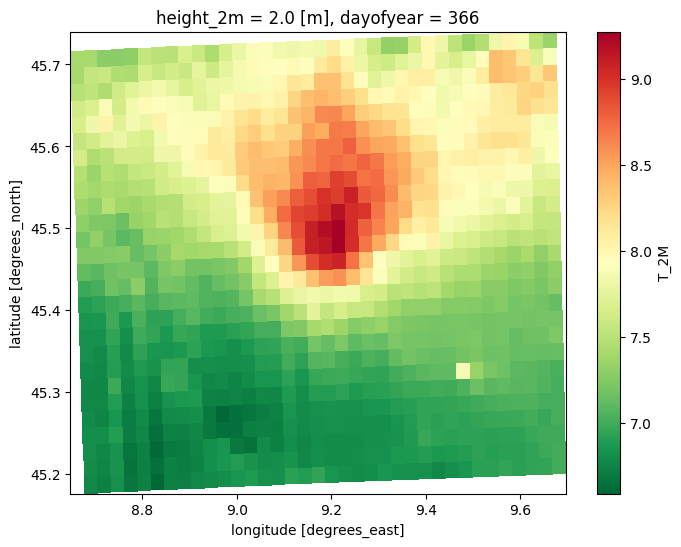

In [19]:
# Let's quickly visualise it
plt.figure(figsize=(8, 6))
daily_max_90p_clim_15.isel(dayofyear=365).plot(cmap="RdYlGn_r", x="lon", y="lat")
plt.show()

In [ ]:
# Export thresholds to nc file
daily_max_90p_clim_15.to_netcdf(".//outputs//Daily_Thresholds_90p_15_long.nc")

Let's move on to calculating HWs for 2022

### HWs for 2022

In [20]:
# Compute maximum daily temperature for 2022
daily_max_2022 = ds_2022["T_2M"].resample(time="1D").max()
daily_max_2022.to_netcdf(".//outputs//max_daily_temp_2022.nc")
daily_max_2022

<xarray.DataArray 'T_2M' (time: 365, rlat: 27, rlon: 36)> Size: 1MB
array([[[11.229675 , 11.262054 , 11.472748 , ..., 11.164764 ,
         11.155121 , 11.192352 ],
        [11.204773 , 11.242523 , 11.463745 , ..., 11.113312 ,
         11.166901 , 11.164429 ],
        [11.235352 , 11.255585 , 11.49823  , ..., 11.13443  ,
         11.140961 , 11.064209 ],
        ...,
        [12.926392 , 12.8732605, 13.165375 , ..., 12.906525 ,
         13.041504 , 13.412476 ],
        [13.17746  , 13.121155 , 13.4626465, ..., 12.849731 ,
         13.075317 , 13.717468 ],
        [13.544342 , 13.53717  , 13.697845 , ..., 13.146423 ,
         13.598175 , 14.104675 ]],

       [[ 9.782745 ,  9.806274 ,  9.957153 , ...,  9.79892  ,
          9.789825 ,  9.815796 ],
        [ 9.610779 ,  9.657166 ,  9.8315735, ...,  9.819458 ,
          9.831665 ,  9.825989 ],
        [ 9.517731 ,  9.540039 ,  9.719513 , ...,  9.885223 ,
          9.866669 ,  9.821045 ],
...
        [ 7.3728943,  7.478607 ,  7.5991516, ...,  7.86734  ,
          7.695465 ,  7.8718567],
        [ 7.251251 ,  7.480957 ,  7.465576 , ...,  7.6225586,
          7.276062 ,  7.329773 ],
        [ 7.2942505,  7.144043 ,  7.087494 , ...,  7.61438  ,
          7.1683655,  7.5810547]],

       [[ 7.6106873,  7.541931 ,  7.7724915, ...,  9.547791 ,
          9.608826 ,  9.651337 ],
        [ 7.716339 ,  7.646393 ,  7.8374634, ...,  9.483978 ,
          9.567322 ,  9.575623 ],
        [ 7.7057495,  7.731781 ,  7.9165955, ...,  9.462189 ,
          9.470642 ,  9.447205 ],
        ...,
        [10.57312  , 10.614655 , 10.603119 , ...,  9.687256 ,
          9.749115 ,  9.96991  ],
        [10.444397 , 10.480255 , 10.578217 , ..., 10.202454 ,
          9.8497925, 10.306549 ],
        [10.3688965, 10.297821 , 10.198669 , ..., 10.349701 ,
         10.618378 , 10.262634 ]]], dtype=float32)
Coordinates:
    lon        (rlat, rlon) float32 4kB ...
    height_2m  float32 4B ...
  * rlon       (rlon) float64 288B -2.333 -2.313 -2.293 ... -1.673 -1.653 -1.633
  * rlat       (rlat) float64 216B 2.232 2.252 2.272 2.292 ... 2.712 2.732 2.752
    lat        (rlat, rlon) float32 4kB ...
  * time       (time) datetime64[ns] 3kB 2022-01-01 2022-01-02 ... 2022-12-31

In [21]:
# Align percentile dataset by day of year
threshold_2022 = daily_max_90p_clim_15.sel(dayofyear=daily_max_2022["time"].dt.dayofyear)

In [22]:
# Create HW boolean mask (True if daily max > threshold)
heatwave_mask = daily_max_2022 > threshold_2022
#heatwave_mask.to_netcdf(".//outputs//heatwave_boolean_2022.nc")

In [23]:
# Let's see the number of HW days per pixel
hw_days_per_pixel = heatwave_mask.sum(dim="time")
hw_days_per_pixel

<xarray.DataArray 'T_2M' (rlat: 27, rlon: 36)> Size: 4kB
array([[152, 151, 152, 149, 155, 152, 147, 151, 151, 149, 150, 150, 152,
        155, 156, 151, 150, 149, 151, 152, 150, 154, 154, 151, 149, 153,
        151, 151, 150, 152, 153, 150, 153, 152, 151, 150],
       [155, 154, 156, 151, 156, 153, 150, 148, 155, 153, 151, 152, 152,
        156, 153, 152, 151, 153, 153, 150, 151, 149, 153, 149, 150, 150,
        152, 153, 151, 154, 153, 151, 152, 151, 151, 149],
       [155, 150, 153, 149, 151, 148, 149, 151, 156, 152, 152, 156, 153,
        152, 151, 154, 152, 155, 152, 153, 154, 152, 151, 150, 151, 151,
        153, 152, 152, 151, 151, 152, 155, 150, 152, 149],
       [157, 154, 150, 154, 152, 151, 147, 154, 154, 157, 152, 157, 149,
        151, 149, 155, 154, 153, 154, 152, 151, 152, 150, 149, 151, 151,
        151, 153, 150, 152, 152, 154, 151, 151, 147, 150],
       [153, 149, 152, 150, 155, 149, 147, 155, 149, 151, 151, 153, 151,
        152, 149, 152, 153, 155, 151, 152, 150, 150, 152, 153, 151, 151,
        154, 151, 151, 155, 153, 153, 151, 153, 154, 151],
       [157, 147, 151, 150, 151, 150, 150, 149, 151, 154, 153, 150, 155,
        153, 150, 155, 152, 153, 153, 149, 150, 151, 150, 154, 148, 151,
        152, 151, 150, 146, 150, 151, 151, 153, 151, 148],
       [154, 156, 154, 152, 154, 149, 148, 151, 151, 149, 150, 151, 151,
        153, 153, 156, 153, 150, 148, 148, 153, 149, 146, 148, 151, 153,
...
        155, 148, 151, 149, 149, 145, 145, 144, 145, 146, 146, 147, 149,
        151, 144, 149, 147, 149, 143, 144, 145, 148, 145],
       [156, 156, 156, 160, 156, 157, 152, 159, 155, 154, 158, 157, 155,
        154, 153, 152, 151, 152, 148, 142, 147, 148, 148, 148, 152, 147,
        154, 144, 147, 153, 146, 147, 146, 148, 151, 143],
       [158, 158, 160, 157, 155, 156, 159, 155, 149, 156, 155, 157, 154,
        161, 154, 152, 151, 154, 149, 149, 153, 149, 150, 152, 152, 150,
        151, 144, 145, 147, 145, 143, 143, 140, 144, 142],
       [158, 158, 158, 162, 156, 157, 158, 150, 149, 157, 155, 159, 155,
        155, 154, 154, 151, 153, 151, 151, 149, 154, 153, 150, 155, 150,
        152, 147, 150, 148, 151, 147, 147, 149, 148, 147],
       [159, 160, 158, 152, 155, 160, 153, 157, 159, 157, 158, 157, 152,
        157, 155, 152, 151, 153, 149, 147, 149, 151, 151, 148, 155, 150,
        155, 149, 150, 148, 146, 146, 146, 141, 146, 141],
       [162, 154, 156, 152, 153, 154, 156, 157, 152, 155, 152, 154, 151,
        157, 155, 152, 153, 158, 150, 146, 152, 146, 148, 150, 153, 153,
        157, 149, 152, 148, 146, 146, 149, 147, 150, 143],
       [160, 157, 157, 160, 156, 155, 155, 155, 153, 155, 156, 156, 153,
        157, 156, 155, 152, 155, 156, 149, 149, 149, 145, 145, 145, 146,
        154, 146, 148, 146, 152, 151, 148, 146, 150, 144]])
Coordinates:
    lon        (rlat, rlon) float32 4kB 8.691 8.719 8.748 ... 9.605 9.634 9.663
    height_2m  float32 4B 2.0
  * rlon       (rlon) float64 288B -2.333 -2.313 -2.293 ... -1.673 -1.653 -1.633
  * rlat       (rlat) float64 216B 2.232 2.252 2.272 2.292 ... 2.712 2.732 2.752
    lat        (rlat, rlon) float32 4kB 45.19 45.19 45.19 ... 45.73 45.73 45.73

We have multidimensional data with a spatial component that is tricky to handle. At this point we have True/False mask for each day of 2022. We can aggregate all pixels into one daily value to check which day was considered an HW (based on the majority of True >90%). This aggregation can be justified by the fact that HWs are big-scale phenomena, so our relatively small area of interest should give a unique/matching spatial response (HW True or HW False). We will also check this later with a comparison to ARPA stations' derived HWs.

In [24]:
# Calculate the majority HW occurrence per day (if >90% pixels are True, mark as True)
hw_majority = heatwave_mask.mean(dim=["rlat", "rlon"]) > 0.90
hw_majority = hw_majority.to_dataframe(name="heatwave_occurrence").reset_index()

In [25]:
print(hw_majority.to_string())

          time  height_2m  dayofyear  heatwave_occurrence
0   2022-01-01        2.0          1                 True
1   2022-01-02        2.0          2                 True
2   2022-01-03        2.0          3                False
3   2022-01-04        2.0          4                False
4   2022-01-05        2.0          5                 True
5   2022-01-06        2.0          6                False
6   2022-01-07        2.0          7                False
7   2022-01-08        2.0          8                False
8   2022-01-09        2.0          9                False
9   2022-01-10        2.0         10                False
10  2022-01-11        2.0         11                False
11  2022-01-12        2.0         12                False
12  2022-01-13        2.0         13                False
13  2022-01-14        2.0         14                False
14  2022-01-15        2.0         15                False
15  2022-01-16        2.0         16                False
16  2022-01-17

In [26]:
print(hw_majority["heatwave_occurrence"].value_counts())

heatwave_occurrence
False    239
True     126
Name: count, dtype: int64


In [ ]:
hw_majority.to_csv(".//outputs//hw_majority_CMCC_ARPA_overlap_15d.csv")

### HW intensity
Let's calculate intensity for all the days so we can select only those HWs that have the highest intensity.

In [27]:
diff_intensity  = daily_max_2022 - threshold_2022

In [28]:
mean_intensity = diff_intensity.mean(dim=['rlat', 'rlon'], skipna=True)

In [29]:
mean_intensity = mean_intensity.to_dataframe(name="HW_intensity").reset_index()

In [30]:
mean_intensity

,time,height_2m,dayofyear,HW_intensity
0,2022-01-01,2.0,1,4.378467
1,2022-01-02,2.0,2,2.191428
2,2022-01-03,2.0,3,1.014090
3,2022-01-04,2.0,4,0.174500
4,2022-01-05,2.0,5,3.144758
...,...,...,...,...
360,2022-12-27,2.0,361,1.566190
361,2022-12-28,2.0,362,-0.485940
362,2022-12-29,2.0,363,-1.344589
363,2022-12-30,2.0,364,-0.416247


In [31]:
# Merge HW occurrence & intensity into one df
merged_HW = pd.merge(mean_intensity, hw_majority, on='time')[['time','HW_intensity', 'heatwave_occurrence']]

In [32]:
merged_HW.head(60)

,time,HW_intensity,heatwave_occurrence
0,2022-01-01,4.378467,True
1,2022-01-02,2.191428,True
2,2022-01-03,1.014090,False
3,2022-01-04,0.174500,False
4,2022-01-05,3.144758,True
5,2022-01-06,-1.238616,False
6,2022-01-07,-3.292118,False
7,2022-01-08,-3.221375,False
8,2022-01-09,-2.647631,False
9,2022-01-10,-1.808129,False


In [33]:
# Assuming merged_HW DataFrame is already defined with 'time', 'HW_intensity', 'heatwave_occurrence'
merged_HW['time'] = pd.to_datetime(merged_HW['time'])

# Step 1: Identify consecutive heatwave days
merged_HW['heatwave_group'] = (merged_HW['heatwave_occurrence'] != merged_HW['heatwave_occurrence'].shift()).cumsum()

# Step 2: Filter only the heatwaves (where heatwave_occurrence is True)
heatwaves = merged_HW[merged_HW['heatwave_occurrence']]

# Step 3: Group by heatwave and filter those that are at least 3 days long
heatwave_groups = heatwaves.groupby('heatwave_group').filter(lambda group: len(group) >= 3)

# Step 4: Calculate the start and end date of each heatwave, the number of days, and cumulative and average intensity
heatwave_summary = heatwave_groups.groupby('heatwave_group').agg(
    start_date=('time', 'min'),
    end_date=('time', 'max'),
    num_days=('time', 'size'),
    cumulative_intensity=('HW_intensity', 'sum'),
    average_intensity=('HW_intensity', 'mean')
).reset_index()

# Result
print(heatwave_summary)


    heatwave_group start_date   end_date  num_days  cumulative_intensity  \
0                5 2022-01-28 2022-01-31         4              6.733873   
1               11 2022-02-08 2022-02-11         4              4.449747   
2               15 2022-02-19 2022-02-23         5             10.415944   
3               17 2022-03-24 2022-03-29         6              6.529448   
4               21 2022-04-13 2022-04-16         4              9.681634   
5               23 2022-05-10 2022-05-24        15             45.059462   
6               25 2022-05-26 2022-05-28         3              8.262614   
7               29 2022-06-04 2022-06-06         3             12.820235   
8               31 2022-06-11 2022-06-21        11             33.988258   
9               37 2022-07-02 2022-07-05         4             10.286137   
10              39 2022-07-15 2022-07-26        12             34.274891   
11              43 2022-08-03 2022-08-06         4              8.287853   
12          

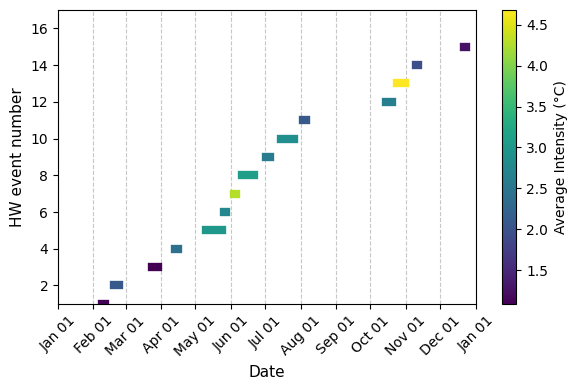

In [34]:
# Normalize the average intensity for colormap scaling
norm = mcolors.Normalize(vmin=heatwave_summary['average_intensity'].min(), vmax=heatwave_summary['average_intensity'].max())
cmap = cm.viridis 
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

fig, ax = plt.subplots(figsize=(6, 4))

# Plot each heatwave with a color corresponding to its average intensity
for idx, row in heatwave_summary.iterrows():
    color = sm.to_rgba(row['average_intensity'])
    ax.plot([row['start_date'], row['end_date']], [idx, idx], color=color, lw=6, label='Heatwave' if idx == 0 else "")

# Add colorbar for intensity scale
fig.colorbar(sm, ax=ax, label='Average Intensity (°C)')

#ax.set_title('Heatwaves during 2022', fontsize=12)
ax.set_xlabel('Date', fontsize=11)
ax.set_xlim(pd.Timestamp('2022-01'), pd.Timestamp('2023-01'))
ax.set_ylabel('HW event number', fontsize=11)
ax.set_ylim(1,17)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('heatwaves_2022.png', dpi=600)
plt.show()

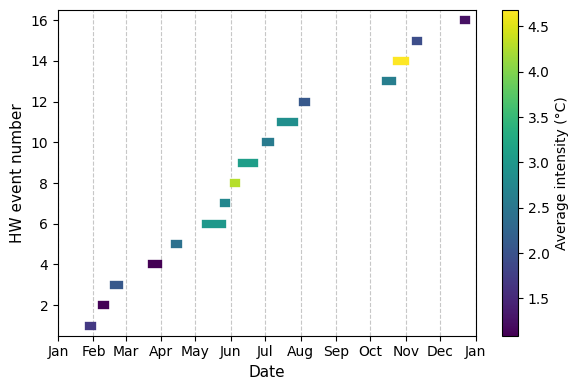

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

# Normalize the average intensity for colormap scaling
norm = mcolors.Normalize(
    vmin=heatwave_summary['average_intensity'].min(),
    vmax=heatwave_summary['average_intensity'].max()
)
cmap = cm.viridis
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig, ax = plt.subplots(figsize=(6, 4))

# Plot each heatwave
for idx, row in heatwave_summary.iterrows():
    color = sm.to_rgba(row['average_intensity'])
    ax.plot([row['start_date'], row['end_date']], [idx + 1, idx + 1], color=color, lw=6)

# Colorbar
fig.colorbar(sm, ax=ax, label='Average intensity (°C)')

# Labels and limits
ax.set_xlabel('Date', fontsize=11)
ax.set_xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-01-01'))
ax.set_ylabel('HW event number', fontsize=11)
ax.set_ylim(0.5, 16.5)

# Show only month names
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xticks(rotation=0)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('heatwaves_2022.png', dpi=600)
plt.show()